SPACESHIP TITANIC

Dataset Description

In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

File and Data Field Descriptions

train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
    
PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Destination - The planet the passenger will be debarking to.

Age - The age of the passenger.

VIP - Whether the passenger has paid for special VIP service during the voyage.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

Name - The first and last names of the passenger.

Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.

sample_submission.csv - A submission file in the correct format.

PassengerId - Id for each passenger in the test set.

Transported - The target. For each passenger, predict either True or False

In [198]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.metrics import classification_report,confusion_matrix,RocCurveDisplay
import itertools
import warnings                   
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format

In [174]:
df=pd.read_csv("spc_train.csv")

In [175]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [176]:
df.shape

(8693, 14)

In [177]:
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [178]:
df.dropna(inplace=True)

In [179]:
df.duplicated().sum()

0

In [180]:
df.shape

(6606, 14)

In [181]:
#checking unique feature names,occurance,n_times
for i in df.columns:
    print(i,'\n')
    print(df[i].unique(),'\n')
    print(df[i].nunique(),'\n')

PassengerId 

['0001_01' '0002_01' '0003_01' ... '9279_01' '9280_01' '9280_02'] 

6606 

HomePlanet 

['Europa' 'Earth' 'Mars'] 

3 

CryoSleep 

[False True] 

2 

Cabin 

['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S'] 

5305 

Destination 

['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e'] 

3 

Age 

[39. 24. 58. 33. 16. 44. 26. 35. 14. 45. 32. 48. 28.  0.  1. 49. 10.  7.
 15. 34. 43. 47.  2. 23. 20. 17. 55.  4. 21. 56. 25. 38. 27. 36. 22. 62.
 18. 19. 37. 42. 13. 40.  3. 54.  9.  6. 29. 64. 67. 61. 50. 31.  8. 51.
 11. 41. 30. 46. 60. 63. 57.  5. 79. 68. 59. 74. 12. 65. 53. 71. 52. 75.
 76. 78. 70. 73. 66. 69. 72. 77.] 

80 

VIP 

[False True] 

2 

RoomService 

[   0.  109.   43. ... 1003. 8586.  745.] 

1093 

FoodCourt 

[   0.    9. 3576. ... 1146. 6819. 4688.] 

1293 

ShoppingMall 

[0.0000e+00 2.5000e+01 3.7100e+02 1.5100e+02 3.0000e+00 1.7000e+01
 5.8900e+02 1.1230e+03 6.5000e+01 1.2000e+01 1.0000e+00 1.3600e+02
 8.1000e+01 1.4110e+03 4.5000e+01 1.8000e+02 1.93

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6606 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   6606 non-null   object 
 1   HomePlanet    6606 non-null   object 
 2   CryoSleep     6606 non-null   object 
 3   Cabin         6606 non-null   object 
 4   Destination   6606 non-null   object 
 5   Age           6606 non-null   float64
 6   VIP           6606 non-null   object 
 7   RoomService   6606 non-null   float64
 8   FoodCourt     6606 non-null   float64
 9   ShoppingMall  6606 non-null   float64
 10  Spa           6606 non-null   float64
 11  VRDeck        6606 non-null   float64
 12  Name          6606 non-null   object 
 13  Transported   6606 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 729.0+ KB


<AxesSubplot:>

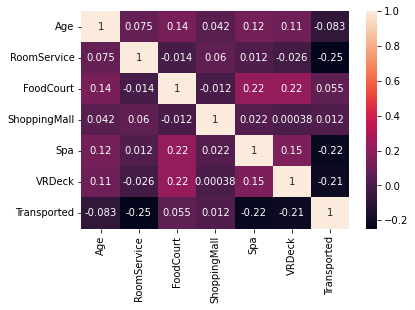

In [183]:
import seaborn as sn
import matplotlib.pyplot as plt

sn.heatmap(df.corr(),annot=True)

In [184]:
df['Transported']=df.Transported.astype(object)

In [185]:
## segregate numerical and categorical columns

numerical_columns=df.columns[df.dtypes!='object']
categorical_columns=df.columns[df.dtypes=='object']
print("Numerical columns:",numerical_columns)
print('Categorical Columns:',categorical_columns)

Numerical columns: Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')
Categorical Columns: Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP',
       'Name', 'Transported'],
      dtype='object')


In [186]:
numerical_data=df[numerical_columns]
numerical_data

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,39.0,0.0,0.0,0.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0
4,16.0,303.0,70.0,151.0,565.0,2.0
...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0
8689,18.0,0.0,0.0,0.0,0.0,0.0
8690,26.0,0.0,0.0,1872.0,1.0,0.0
8691,32.0,0.0,1049.0,0.0,353.0,3235.0


In [187]:
numerical_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6606 entries, 0 to 8692
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           6606 non-null   float64
 1   RoomService   6606 non-null   float64
 2   FoodCourt     6606 non-null   float64
 3   ShoppingMall  6606 non-null   float64
 4   Spa           6606 non-null   float64
 5   VRDeck        6606 non-null   float64
dtypes: float64(6)
memory usage: 361.3 KB


In [188]:
categorical_data=df[categorical_columns]
categorical_data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,False,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,False,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,True,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,False,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,False,Willy Santantines,True
...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,True,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,False,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,False,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,False,Celeon Hontichre,False


In [189]:
cat_df=categorical_data.drop(["PassengerId","Cabin","Name"],axis="columns")
cat_df

,HomePlanet,CryoSleep,Destination,VIP,Transported
0,Europa,False,TRAPPIST-1e,False,False
1,Earth,False,TRAPPIST-1e,False,True
2,Europa,False,TRAPPIST-1e,True,False
3,Europa,False,TRAPPIST-1e,False,False
4,Earth,False,TRAPPIST-1e,False,True
...,...,...,...,...,...
8688,Europa,False,55 Cancri e,True,False
8689,Earth,True,PSO J318.5-22,False,False
8690,Earth,False,TRAPPIST-1e,False,True
8691,Europa,False,55 Cancri e,False,False


In [190]:
lb=LabelEncoder()
for i in cat_df:
    cat_df[i]=lb.fit_transform(df[i])

df=pd.concat([numerical_data,cat_df],axis=1)

In [191]:
dff=pd.concat([numerical_data,cat_df],axis=1)
dff.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet,CryoSleep,Destination,VIP,Transported
0,39.0,0.0,0.0,0.0,0.0,0.0,1,0,2,0,0
1,24.0,109.0,9.0,25.0,549.0,44.0,0,0,2,0,1
2,58.0,43.0,3576.0,0.0,6715.0,49.0,1,0,2,1,0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,1,0,2,0,0
4,16.0,303.0,70.0,151.0,565.0,2.0,0,0,2,0,1


In [192]:
X=dff.iloc[:,:-1]
y=dff.iloc[:,-1:]

In [193]:
y

,Transported
0,0
1,1
2,0
3,0
4,1
...,...
8688,0
8689,0
8690,1
8691,0


In [194]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [195]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((5284, 10), (1322, 10), (5284, 1), (1322, 1))

In [200]:
sc=StandardScaler()
X_train=sc.fit_transform(X_train)

In [201]:
X_train

array([[ 0.22051462, -0.34704629, -0.28209937, ...,  1.3539734 ,
         0.64294679, -0.16314854],
       [-1.70452544, -0.34704629, -0.28209937, ...,  1.3539734 ,
         0.64294679, -0.16314854],
       [ 0.08301176, -0.34704629, -0.14334471, ..., -0.73856695,
         0.64294679, -0.16314854],
       ...,
       [ 0.49552034, -0.34704629,  2.51415978, ..., -0.73856695,
         0.64294679, -0.16314854],
       [ 0.35801748, -0.34704629, -0.2797476 , ..., -0.73856695,
         0.64294679,  6.12938358],
       [-1.01701113, -0.34393854,  0.23587883, ..., -0.73856695,
         0.64294679, -0.16314854]])

In [202]:
X_test

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet,CryoSleep,Destination,VIP
2453,50.00,0.00,0.00,0.00,0.00,0.00,2,1,0,0
1334,18.00,0.00,0.00,0.00,0.00,0.00,0,1,1,0
8272,15.00,0.00,0.00,0.00,0.00,0.00,0,1,0,0
5090,52.00,0.00,0.00,0.00,0.00,0.00,0,1,1,0
4357,62.00,0.00,1633.00,0.00,1742.00,0.00,1,0,2,1
...,...,...,...,...,...,...,...,...,...,...
85,19.00,0.00,0.00,670.00,1.00,34.00,0,0,2,0
6816,37.00,300.00,3434.00,0.00,1.00,171.00,1,0,2,0
5926,43.00,2.00,5329.00,0.00,7.00,0.00,1,0,2,0
3793,14.00,0.00,0.00,0.00,0.00,0.00,0,1,1,0


In [203]:
X_test=sc.transform(X_test)

In [204]:
X_test

array([[ 1.45804037, -0.34704629, -0.28209937, ...,  1.3539734 ,
        -1.77680451, -0.16314854],
       [-0.74200541, -0.34704629, -0.28209937, ...,  1.3539734 ,
        -0.56692886, -0.16314854],
       [-0.9482597 , -0.34704629, -0.28209937, ...,  1.3539734 ,
        -1.77680451, -0.16314854],
       ...,
       [ 0.97678035, -0.34393854,  2.85105139, ..., -0.73856695,
         0.64294679, -0.16314854],
       [-1.01701113, -0.34704629, -0.28209937, ...,  1.3539734 ,
        -0.56692886, -0.16314854],
       [ 0.15176319, -0.34704629, -0.28209937, ...,  1.3539734 ,
         0.64294679, -0.16314854]])

In [205]:
#compute mulitiple models by using function
Model = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    GaussianNB()
    ] 



log_cols=["Model", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in Model:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    
    print('='*35)
    print("Model",name)
    
    
    test_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, test_predictions)
    print("Accuracy: {:.5%}".format(acc))
    
    test_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, test_predictions)
    print("Log Loss: {:.5}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
       

Model LogisticRegression
Accuracy: 78.51740%
Log Loss: 0.46596
Model DecisionTreeClassifier
Accuracy: 74.43268%
Log Loss: 6.5797
Model RandomForestClassifier
Accuracy: 78.59304%
Log Loss: 0.67491
Model XGBClassifier
Accuracy: 77.91225%
Log Loss: 0.4586
Model KNeighborsClassifier
Accuracy: 75.26475%
Log Loss: 3.2834
Model SVC
Accuracy: 76.70197%
Log Loss: 0.50671
Model GaussianNB
Accuracy: 69.59153%
Log Loss: 1.3775


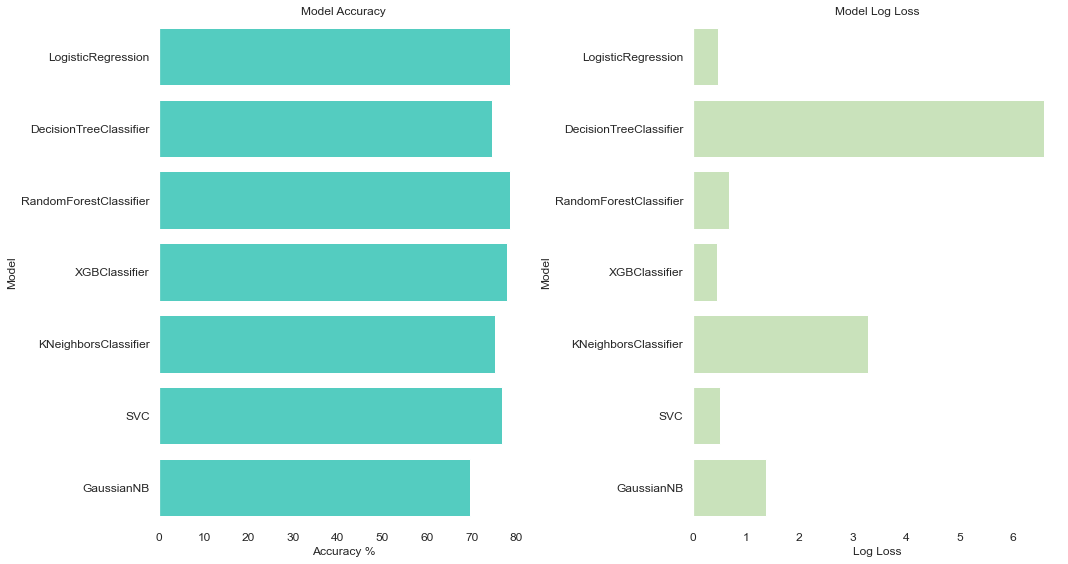

In [206]:
## Visualising the accuracy & log loss data
#select color picker from google(https://www.google.com/search?q=%2340E0D0&rlz=1C1VDKB_enIN1030IN1031&sxsrf=APwXEdcxjpD9ffV6E8v6M2BOj78g-jrY4w%3A1687759085498&ei=7SiZZPOHHpTZseMPsLCEUA&ved=0ahUKEwizsofGoOD_AhWUbGwGHTAYAQoQ4dUDCA8&uact=5&oq=%2340E0D0&gs_lcp=Cgxnd3Mtd2l6LXNlcnAQAzIKCAAQRxDWBBCwAzIKCAAQRxDWBBCwAzIKCAAQRxDWBBCwAzIKCAAQRxDWBBCwAzIKCAAQRxDWBBCwAzIKCAAQRxDWBBCwAzIKCAAQRxDWBBCwAzIKCAAQRxDWBBCwA0oECEEYAFAAWABgwAFoAXABeACAAQCIAQCSAQCYAQDAAQHIAQg&sclient=gws-wiz-serp#cobssid=s)

sns.set(rc={'axes.facecolor':'none','axes.grid':False,'xtick.labelsize':12,'ytick.labelsize':12, 'figure.autolayout':True})
plt.subplots(figsize=(15,8))

plt.subplot(1,2,1)
sns.set_color_codes("bright")
sns.barplot(x='Accuracy', y='Model', data=log, color='#40E0D0')
plt.xlabel('Accuracy %')
plt.title('Model Accuracy', fontdict={'fontsize':12})

plt.subplot(1,2,2)
sns.set_color_codes("bright")
sns.barplot(x='Log Loss', y='Model', data=log, color='#c7e9b4')
plt.xlabel('Log Loss')
plt.title('Model Log Loss', fontdict={'fontsize':12})

plt.show()

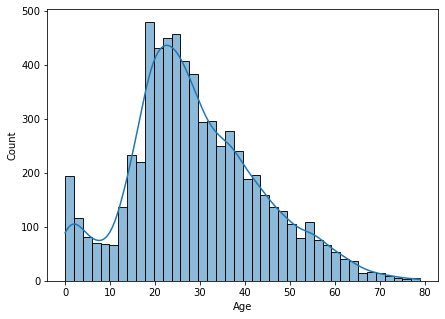

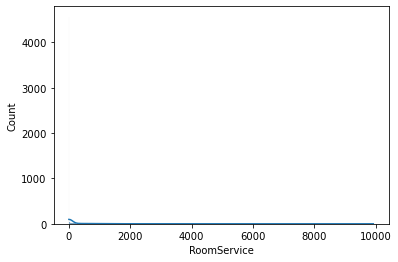

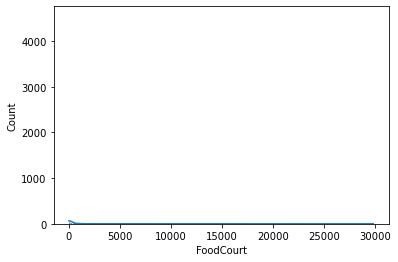

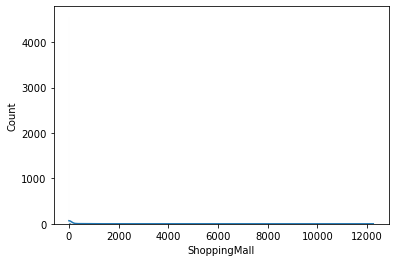

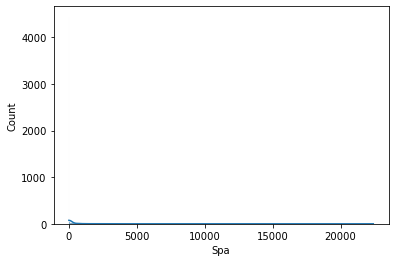

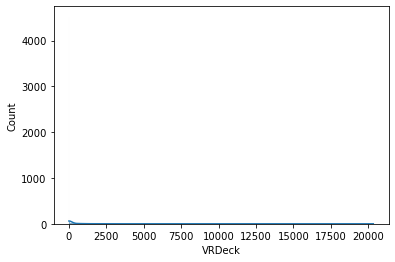

ValueError: object arrays are not supported

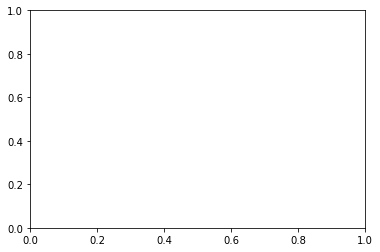

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
x=0
for i in numerical_columns:
    sns.histplot(data=df,x=i,kde=True)
    print("\n")
    plt.show()

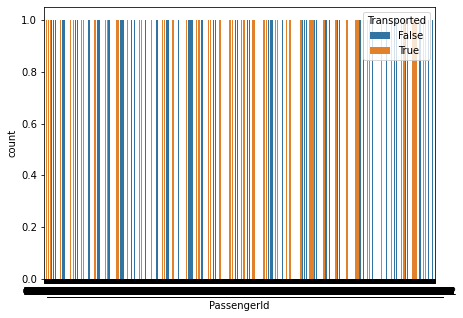

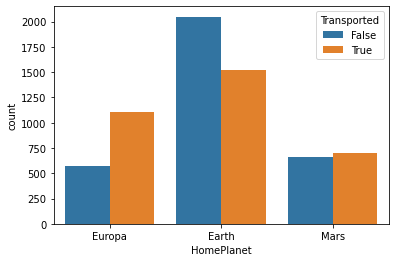

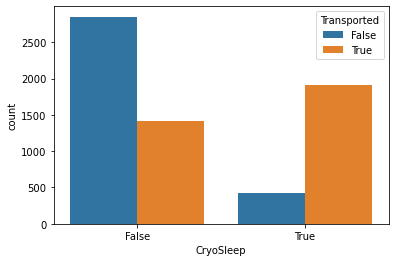

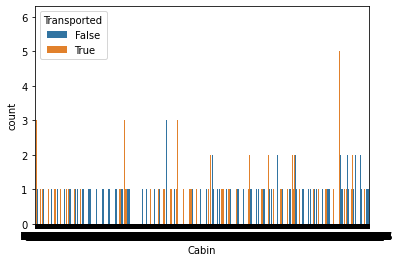

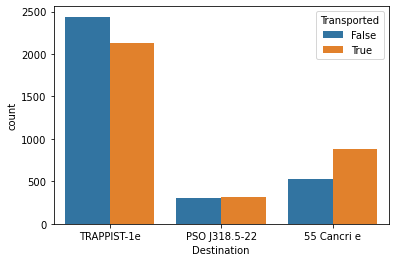

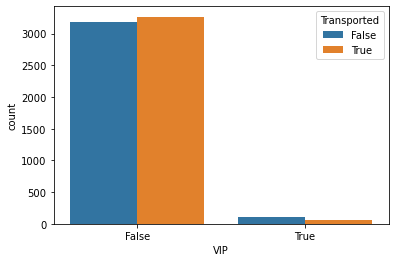

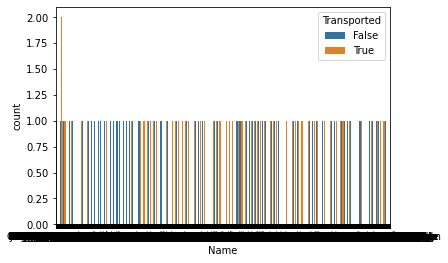

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
x=0
for i in categorical_columns:
    sns.countplot(x=df[i],hue=df.Transported)
    print("\n")
    plt.show()